# **Lecture 5: Excercise**

This code is directly copied from scikit website. Your tasks for this excercise is:
>
>- 1, Run the code and understand it
>- 2, Write a brief summary of this project


## 1, Tweedie regression on insurance claims

This example illustrates the use of Poisson, Gamma and Tweedie regression on
the [French Motor Third-Party Liability Claims dataset](https://www.openml.org/d/41214), and is inspired by an R tutorial [1]_.

In this dataset, each sample corresponds to an insurance policy, i.e. a
contract within an insurance company and an individual (policyholder).
Available features include driver age, vehicle age, vehicle power, etc.

A few definitions: a *claim* is the request made by a policyholder to the
insurer to compensate for a loss covered by the insurance. The *claim amount*
is the amount of money that the insurer must pay. The *exposure* is the
duration of the insurance coverage of a given policy, in years.

Here our goal is to predict the expected
value, i.e. the mean, of the total claim amount per exposure unit also
referred to as the pure premium.

There are several possibilities to do that, two of which are:

1. Model the number of claims with a Poisson distribution, and the average
   claim amount per claim, also known as severity, as a Gamma distribution
   and multiply the predictions of both in order to get the total claim
   amount.
2. Model the total claim amount per exposure directly, typically with a Tweedie
   distribution of Tweedie power $p \in (1, 2)$.

In this example we will illustrate both approaches. We start by defining a few
helper functions for loading the data and visualizing results.

.. [1]  A. Noll, R. Salzmann and M.V. Wuthrich, Case Study: French Motor
    Third-Party Liability Claims (November 8, 2018). [doi:10.2139/ssrn.3164764](http://dx.doi.org/10.2139/ssrn.3164764)


In [1]:
# Authors: Christian Lorentzen <lorentzen.ch@gmail.com>
#          Roman Yurchak <rth.yurchak@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
# License: BSD 3 clause

In [2]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_tweedie_deviance
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


def load_mtpl2(n_samples=None):
    """Fetch the French Motor Third-Party Liability Claims dataset.

    Parameters
    ----------
    n_samples: int, default=None
      number of samples to select (for faster run time). Full dataset has
      678013 samples.
    """
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True, parser="pandas").data
    df_freq["IDpol"] = df_freq["IDpol"].astype(int)
    df_freq.set_index("IDpol", inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True, parser="pandas").data

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby("IDpol").sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # unquote string fields
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]


def plot_obs_pred(
    df,
    feature,
    weight,
    observed,
    predicted,
    y_label=None,
    title=None,
    ax=None,
    fill_legend=False,
):
    """Plot observed and predicted - aggregated per feature level.

    Parameters
    ----------
    df : DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight : str
        column name of df with the values of weights or exposure
    observed : str
        a column name of df with the observed target
    predicted : DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend : bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [feature, weight]].copy()
    df_["observed"] = df[observed] * df[weight]
    df_["predicted"] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )

    ax = df_.loc[:, ["observed", "predicted"]].plot(style=".", ax=ax)
    y_max = df_.loc[:, ["observed", "predicted"]].values.max() * 0.8
    p2 = ax.fill_between(
        df_.index,
        0,
        y_max * df_[weight] / df_[weight].values.max(),
        color="g",
        alpha=0.1,
    )
    if fill_legend:
        ax.legend([p2], ["{} distribution".format(feature)])
    ax.set(
        ylabel=y_label if y_label is not None else None,
        title=title if title is not None else "Train: Observed vs Predicted",
    )


def score_estimator(
    estimator,
    X_train,
    X_test,
    df_train,
    df_test,
    target,
    weights,
    tweedie_powers=None,
):
    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ("D² explained", None),  # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [
            (
                "mean Tweedie dev p={:.4f}".format(power),
                partial(mean_tweedie_deviance, power=power),
            )
            for power in tweedie_powers
        ]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y, _weights = df[target], df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res.append({"subset": subset_label, "metric": score_label, "score": score})

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ["train", "test"]]
    )
    return res

## 2, Loading datasets, basic feature extraction and target definitions

We construct the freMTPL2 dataset by joining the freMTPL2freq table,
containing the number of claims (``ClaimNb``), with the freMTPL2sev table,
containing the claim amount (``ClaimAmount``) for the same policy ids
(``IDpol``).



In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer


df = load_mtpl2()

# Note: filter out claims with zero amount, as the severity model
# requires strictly positive target values.
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

# Correct for unreasonable observations (that might be data error)
# and a few exceptionally large claim amounts
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)

log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log), StandardScaler()
)

column_trans = ColumnTransformer(
    [
        (
            "binned_numeric",
            KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=0),
            ["VehAge", "DrivAge"],
        ),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
    ],
    remainder="drop",
)
X = column_trans.fit_transform(df)

# Insurances companies are interested in modeling the Pure Premium, that is
# the expected total claim amount per unit of exposure for each policyholder
# in their portfolio:
df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]

# This can be indirectly approximated by a 2-step modeling: the product of the
# Frequency times the average claim amount per claim:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
df["AvgClaimAmount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1)

with pd.option_context("display.max_columns", 15):
    print(df[df.ClaimAmount > 0].head())

       ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
IDpol                                                                           
139          1      0.75    F         7       1       61          50      B12   
190          1      0.14    B        12       5       50          60      B12   
414          1      0.14    E         4       0       36          85      B12   
424          2      0.62    F        10       0       51         100      B12   
463          1      0.31    A         5       0       45          50      B12   

        VehGas  Density Region  ClaimAmount   PurePremium  Frequency  \
IDpol                                                                  
139    Regular    27000    R11       303.00    404.000000   1.333333   
190     Diesel       56    R25      1981.84  14156.000000   7.142857   
414    Regular     4792    R11      1456.55  10403.928571   7.142857   
424    Regular    27000    R11     10834.00  17474.193548   3.225806   


## 3, Frequency model -- Poisson distribution

The number of claims (``ClaimNb``) is a positive integer (0 included).
Thus, this target can be modelled by a Poisson distribution.
It is then assumed to be the number of discrete events occurring with a
constant rate in a given time interval (``Exposure``, in units of years).
Here we model the frequency ``y = ClaimNb / Exposure``, which is still a
(scaled) Poisson distribution, and use ``Exposure`` as `sample_weight`.



In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor


df_train, df_test, X_train, X_test = train_test_split(df, X, random_state=0)

Let us keep in mind that despite the seemingly large number of data points in
this dataset, the number of evaluation points where the claim amount is
non-zero is quite small:



In [6]:
len(df_test)

169504

In [7]:
len(df_test[df_test["ClaimAmount"] > 0])

6237

As a consequence, we expect a significant variability in our
evaluation upon random resampling of the train test split.

The parameters of the model are estimated by minimizing the Poisson deviance
on the training set via a Newton solver. Some of the features are collinear
(e.g. because we did not drop any categorical level in the `OneHotEncoder`),
we use a weak L2 penalization to avoid numerical issues.



In [8]:
glm_freq = PoissonRegressor(alpha=1e-4, solver="newton-cholesky")
glm_freq.fit(X_train, df_train["Frequency"], sample_weight=df_train["Exposure"])

scores = score_estimator(
    glm_freq,
    X_train,
    X_test,
    df_train,
    df_test,
    target="Frequency",
    weights="Exposure",
)
print("Evaluation of PoissonRegressor on target Frequency")
print(scores)

Evaluation of PoissonRegressor on target Frequency
subset               train    test
metric                            
D² explained        0.0201  0.0219
mean abs. error     0.1379  0.1378
mean squared error  0.2441  0.2246


Note that the score measured on the test set is surprisingly better than on
the training set. This might be specific to this random train-test split.
Proper cross-validation could help us to assess the sampling variability of
these results.

We can visually compare observed and predicted values, aggregated by the
drivers age (``DrivAge``), vehicle age (``VehAge``) and the insurance
bonus/malus (``BonusMalus``).



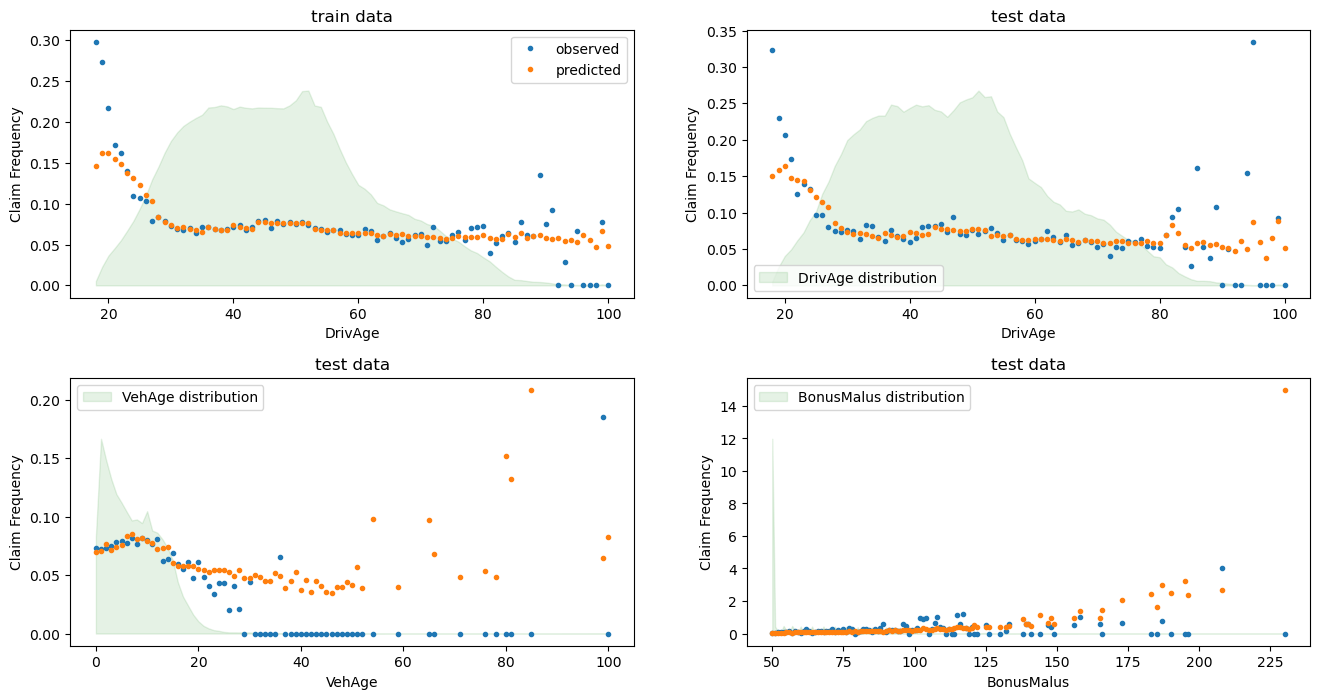

In [9]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plot_obs_pred(
    df=df_train,
    feature="DrivAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_train),
    y_label="Claim Frequency",
    title="train data",
    ax=ax[0, 0],
)

plot_obs_pred(
    df=df_test,
    feature="DrivAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[0, 1],
    fill_legend=True,
)

plot_obs_pred(
    df=df_test,
    feature="VehAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[1, 0],
    fill_legend=True,
)

plot_obs_pred(
    df=df_test,
    feature="BonusMalus",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[1, 1],
    fill_legend=True,
)

According to the observed data, the frequency of accidents is higher for
drivers younger than 30 years old, and is positively correlated with the
`BonusMalus` variable. Our model is able to mostly correctly model this
behaviour.

## 4, Severity Model -  Gamma distribution
The mean claim amount or severity (`AvgClaimAmount`) can be empirically
shown to follow approximately a Gamma distribution. We fit a GLM model for
the severity with the same features as the frequency model.

Note:

- We filter out ``ClaimAmount == 0`` as the Gamma distribution has support
  on $(0, \infty)$, not $[0, \infty)$.
- We use ``ClaimNb`` as `sample_weight` to account for policies that contain
  more than one claim.



In [10]:
from sklearn.linear_model import GammaRegressor


mask_train = df_train["ClaimAmount"] > 0
mask_test = df_test["ClaimAmount"] > 0

glm_sev = GammaRegressor(alpha=10.0, solver="newton-cholesky")

glm_sev.fit(
    X_train[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

scores = score_estimator(
    glm_sev,
    X_train[mask_train.values],
    X_test[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)
print("Evaluation of GammaRegressor on target AvgClaimAmount")
print(scores)

Evaluation of GammaRegressor on target AvgClaimAmount
subset                     train          test
metric                                        
D² explained        2.400000e-03  2.700000e-03
mean abs. error     1.756746e+03  1.744042e+03
mean squared error  5.801770e+07  5.030677e+07


Those values of the metrics are not necessarily easy to interpret. It can be
insightful to compare them with a model that does not use any input
features and always predicts a constant value, i.e. the average claim
amount, in the same setting:



In [11]:
from sklearn.dummy import DummyRegressor

dummy_sev = DummyRegressor(strategy="mean")
dummy_sev.fit(
    X_train[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

scores = score_estimator(
    dummy_sev,
    X_train[mask_train.values],
    X_test[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)
print("Evaluation of a mean predictor on target AvgClaimAmount")
print(scores)

Evaluation of a mean predictor on target AvgClaimAmount
subset                     train          test
metric                                        
D² explained        0.000000e+00 -0.000000e+00
mean abs. error     1.756687e+03  1.744497e+03
mean squared error  5.803882e+07  5.033764e+07


We conclude that the claim amount is very challenging to predict. Still, the
:class:`~sklearn.linear.GammaRegressor` is able to leverage some information
from the input features to slighly improve upon the mean baseline in terms
of D².

Note that the resulting model is the average claim amount per claim. As such,
it is conditional on having at least one claim, and cannot be used to predict
the average claim amount per policy. For this, it needs to be combined with
a claims frequency model.



In [12]:
print(
    "Mean AvgClaim Amount per policy:              %.2f "
    % df_train["AvgClaimAmount"].mean()
)
print(
    "Mean AvgClaim Amount | NbClaim > 0:           %.2f"
    % df_train["AvgClaimAmount"][df_train["AvgClaimAmount"] > 0].mean()
)
print(
    "Predicted Mean AvgClaim Amount | NbClaim > 0: %.2f"
    % glm_sev.predict(X_train).mean()
)
print(
    "Predicted Mean AvgClaim Amount (dummy) | NbClaim > 0: %.2f"
    % dummy_sev.predict(X_train).mean()
)

Mean AvgClaim Amount per policy:              71.78 
Mean AvgClaim Amount | NbClaim > 0:           1951.21
Predicted Mean AvgClaim Amount | NbClaim > 0: 1940.95
Predicted Mean AvgClaim Amount (dummy) | NbClaim > 0: 1978.59


We can visually compare observed and predicted values, aggregated for
the drivers age (``DrivAge``).



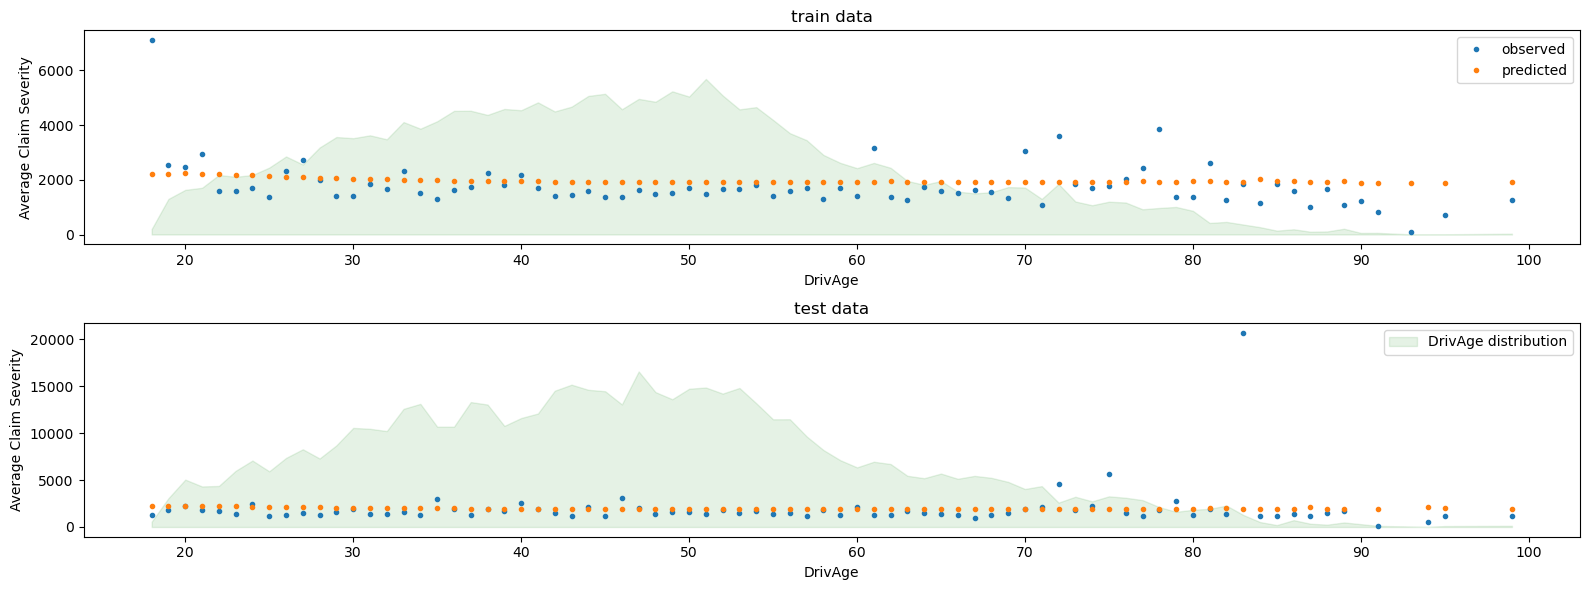

In [13]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 6))

plot_obs_pred(
    df=df_train.loc[mask_train],
    feature="DrivAge",
    weight="Exposure",
    observed="AvgClaimAmount",
    predicted=glm_sev.predict(X_train[mask_train.values]),
    y_label="Average Claim Severity",
    title="train data",
    ax=ax[0],
)

plot_obs_pred(
    df=df_test.loc[mask_test],
    feature="DrivAge",
    weight="Exposure",
    observed="AvgClaimAmount",
    predicted=glm_sev.predict(X_test[mask_test.values]),
    y_label="Average Claim Severity",
    title="test data",
    ax=ax[1],
    fill_legend=True,
)
plt.tight_layout()

Overall, the drivers age (``DrivAge``) has a weak impact on the claim
severity, both in observed and predicted data.

## 5, Pure Premium Modeling via a Product Model vs single TweedieRegressor
As mentioned in the introduction, the total claim amount per unit of
exposure can be modeled as the product of the prediction of the
frequency model by the prediction of the severity model.

Alternatively, one can directly model the total loss with a unique
Compound Poisson Gamma generalized linear model (with a log link function).
This model is a special case of the Tweedie GLM with a "power" parameter
$p \in (1, 2)$. Here, we fix apriori the `power` parameter of the
Tweedie model to some arbitrary value (1.9) in the valid range. Ideally one
would select this value via grid-search by minimizing the negative
log-likelihood of the Tweedie model, but unfortunately the current
implementation does not allow for this (yet).

We will compare the performance of both approaches.
To quantify the performance of both models, one can compute
the mean deviance of the train and test data assuming a Compound
Poisson-Gamma distribution of the total claim amount. This is equivalent to
a Tweedie distribution with a `power` parameter between 1 and 2.

The :func:`sklearn.metrics.mean_tweedie_deviance` depends on a `power`
parameter. As we do not know the true value of the `power` parameter, we here
compute the mean deviances for a grid of possible values, and compare the
models side by side, i.e. we compare them at identical values of `power`.
Ideally, we hope that one model will be consistently better than the other,
regardless of `power`.



In [14]:
from sklearn.linear_model import TweedieRegressor


glm_pure_premium = TweedieRegressor(power=1.9, alpha=0.1, solver="newton-cholesky")
glm_pure_premium.fit(
    X_train, df_train["PurePremium"], sample_weight=df_train["Exposure"]
)

tweedie_powers = [1.5, 1.7, 1.8, 1.9, 1.99, 1.999, 1.9999]

scores_product_model = score_estimator(
    (glm_freq, glm_sev),
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores_glm_pure_premium = score_estimator(
    glm_pure_premium,
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores = pd.concat(
    [scores_product_model, scores_glm_pure_premium],
    axis=1,
    sort=True,
    keys=("Product Model", "TweedieRegressor"),
)
print("Evaluation of the Product Model and the Tweedie Regressor on target PurePremium")
with pd.option_context("display.expand_frame_repr", False):
    print(scores)

Evaluation of the Product Model and the Tweedie Regressor on target PurePremium
                          Product Model               TweedieRegressor              
subset                            train          test            train          test
metric                                                                              
D² explained                        NaN           NaN     1.690000e-02  1.420000e-02
mean Tweedie dev p=1.5000  7.669930e+01  7.617050e+01     7.640770e+01  7.640880e+01
mean Tweedie dev p=1.7000  3.695740e+01  3.683980e+01     3.682880e+01  3.692270e+01
mean Tweedie dev p=1.8000  3.046010e+01  3.040530e+01     3.037600e+01  3.045390e+01
mean Tweedie dev p=1.9000  3.387580e+01  3.385000e+01     3.382120e+01  3.387830e+01
mean Tweedie dev p=1.9900  2.015716e+02  2.015414e+02     2.015347e+02  2.015587e+02
mean Tweedie dev p=1.9990  1.914573e+03  1.914370e+03     1.914538e+03  1.914387e+03
mean Tweedie dev p=1.9999  1.904751e+04  1.904556e+04     1.904747e+04

In this example, both modeling approaches yield comparable performance
metrics. For implementation reasons, the percentage of explained variance
$D^2$ is not available for the product model.

We can additionally validate these models by comparing observed and
predicted total claim amount over the test and train subsets. We see that,
on average, both model tend to underestimate the total claim (but this
behavior depends on the amount of regularization).



In [15]:
res = []
for subset_label, X, df in [
    ("train", X_train, df_train),
    ("test", X_test, df_test),
]:
    exposure = df["Exposure"].values
    res.append(
        {
            "subset": subset_label,
            "observed": df["ClaimAmount"].values.sum(),
            "predicted, frequency*severity model": np.sum(
                exposure * glm_freq.predict(X) * glm_sev.predict(X)
            ),
            "predicted, tweedie, power=%.2f"
            % glm_pure_premium.power: np.sum(exposure * glm_pure_premium.predict(X)),
        }
    )

print(pd.DataFrame(res).set_index("subset").T)

subset                                      train          test
observed                             3.917618e+07  1.299546e+07
predicted, frequency*severity model  3.916555e+07  1.313276e+07
predicted, tweedie, power=1.90       3.951751e+07  1.325198e+07


Finally, we can compare the two models using a plot of cumulated claims: for
each model, the policyholders are ranked from safest to riskiest based on the
model predictions and the fraction of observed total cumulated claims is
plotted on the y axis. This plot is often called the ordered Lorenz curve of
the model.

The Gini coefficient (based on the area between the curve and the diagonal)
can be used as a model selection metric to quantify the ability of the model
to rank policyholders. Note that this metric does not reflect the ability of
the models to make accurate predictions in terms of absolute value of total
claim amounts but only in terms of relative amounts as a ranking metric. The
Gini coefficient is upper bounded by 1.0 but even an oracle model that ranks
the policyholders by the observed claim amounts cannot reach a score of 1.0.

We observe that both models are able to rank policyholders by risky-ness
significantly better than chance although they are also both far from the
oracle model due to the natural difficulty of the prediction problem from a
few features: most accidents are not predictable and can be caused by
environmental circumstances that are not described at all by the input
features of the models.

Note that the Gini index only characterizes the ranking performance of the
model but not its calibration: any monotonic transformation of the predictions
leaves the Gini index of the model unchanged.

Finally one should highlight that the Compound Poisson Gamma model that is
directly fit on the pure premium is operationally simpler to develop and
maintain as it consists of a single scikit-learn estimator instead of a pair
of models, each with its own set of hyperparameters.



[]

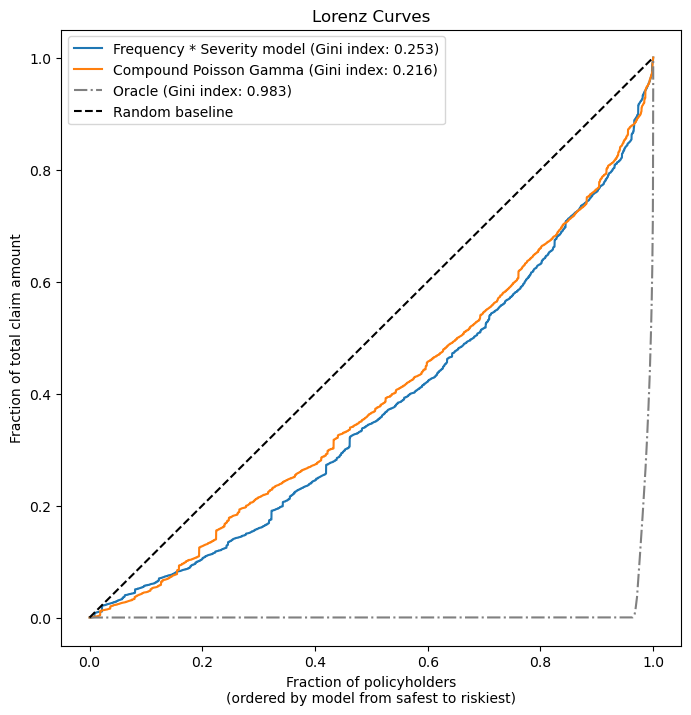

In [16]:
from sklearn.metrics import auc


def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


fig, ax = plt.subplots(figsize=(8, 8))

y_pred_product = glm_freq.predict(X_test) * glm_sev.predict(X_test)
y_pred_total = glm_pure_premium.predict(X_test)

for label, y_pred in [
    ("Frequency * Severity model", y_pred_product),
    ("Compound Poisson Gamma", y_pred_total),
]:
    ordered_samples, cum_claims = lorenz_curve(
        df_test["PurePremium"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += " (Gini index: {:.3f})".format(gini)
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    df_test["PurePremium"], df_test["PurePremium"], df_test["Exposure"]
)
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = "Oracle (Gini index: {:.3f})".format(gini)
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray", label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel="Fraction of policyholders\n(ordered by model from safest to riskiest)",
    ylabel="Fraction of total claim amount",
)
ax.legend(loc="upper left")
plt.plot()